In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# XGBoost
from xgboost import XGBRegressor

DATA_PATH = r"C:/Users/DuminduS/Desktop/UWE/CSCT Masters Project/datasets/Final data/Final02.csv"

df = pd.read_csv(DATA_PATH)

# Parse date (UK)
df["date"] = pd.to_datetime(df["date"], format="mixed", dayfirst=True, errors="coerce")
df = df.dropna(subset=["date", "station_id", "sessions"])

# Ensure numeric
num_cols = [c for c in df.columns if c not in ["station_id", "date"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Sort
df = df.sort_values(["station_id", "date"]).reset_index(drop=True)

print(df.shape)
df.head()


(53067, 17)


,station_id,date,sessions,energy_kwh,mean_charge_duration_min,latitude,longitude,n_connectors,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,snowfall_sum,windspeed_10m_max,windspeed_10m_mean,avg_daily_traffic_nearby
0,BRI_0000,2024-01-01,22,602.991,133.911205,51.542927,-2.568751,6,12.0,7.3,8.7,16.6,16.6,0.0,43.0,25.5,8465
1,BRI_0000,2024-01-02,44,984.970,136.226415,51.542927,-2.568751,6,13.4,9.1,10.7,8.7,8.7,0.0,53.7,29.7,8465
2,BRI_0000,2024-01-03,32,582.430,136.061438,51.542927,-2.568751,6,9.7,7.8,8.7,2.2,2.2,0.0,27.9,23.8,8465
3,BRI_0000,2024-01-04,32,753.940,161.179459,51.542927,-2.568751,6,8.3,5.4,6.8,8.4,8.4,0.0,28.5,16.8,8465
4,BRI_0000,2024-01-05,40,797.936,114.216709,51.542927,-2.568751,6,7.5,3.8,5.3,0.0,0.0,0.0,14.5,9.9,8465


In [4]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
TARGET = "sessions"
HORIZON_DAYS = 1  # t+1 forecasting


In [6]:
#Time features
df["day_of_week"] = df["date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int)
df["month"] = df["date"].dt.month
df["day_of_month"] = df["date"].dt.day

# Create the forecasting target: y(t) = sessions(t + horizon)
df["y"] = df.groupby("station_id")[TARGET].shift(-HORIZON_DAYS)

#Lag features from past sessions
df["lag_1"] = df.groupby("station_id")[TARGET].shift(1)
df["lag_7"] = df.groupby("station_id")[TARGET].shift(7)
df["lag_14"] = df.groupby("station_id")[TARGET].shift(14)

# Rolling means
df["roll_7_mean"]  = df.groupby("station_id")[TARGET].rolling(7).mean().reset_index(level=0, drop=True)
df["roll_30_mean"] = df.groupby("station_id")[TARGET].rolling(30).mean().reset_index(level=0, drop=True)

#Rolling variability
df["roll_7_std"] = df.groupby("station_id")[TARGET].rolling(7).std().reset_index(level=0, drop=True)

# Drop rows can't have features due to rolling
df_model = df.dropna(subset=["y", "lag_1", "lag_7", "roll_7_mean", "roll_30_mean"]).copy()

print("Model-ready rows:", df_model.shape)
df_model.head()


Model-ready rows: (48717, 28)


,station_id,date,sessions,energy_kwh,mean_charge_duration_min,latitude,longitude,n_connectors,temperature_2m_max,temperature_2m_min,...,is_weekend,month,day_of_month,y,lag_1,lag_7,lag_14,roll_7_mean,roll_30_mean,roll_7_std
29,BRI_0000,2024-01-30,32,641.606,128.954625,51.542927,-2.568751,6,10.5,5.8,...,0,1,30,46.0,34.0,39.0,31.0,38.428571,35.8,6.187545
30,BRI_0000,2024-01-31,46,1164.652,131.599672,51.542927,-2.568751,6,11.1,2.8,...,0,1,31,29.0,32.0,42.0,37.0,39.000000,36.6,6.733003
31,BRI_0000,2024-02-01,29,774.979,139.356025,51.542927,-2.568751,6,10.1,3.5,...,0,2,1,41.0,46.0,49.0,32.0,36.142857,36.1,5.984106
32,BRI_0000,2024-02-02,41,660.415,230.394720,51.542927,-2.568751,6,11.2,6.4,...,0,2,2,35.0,29.0,42.0,37.0,36.000000,36.4,5.830952
33,BRI_0000,2024-02-03,35,642.248,178.874093,51.542927,-2.568751,6,10.4,9.6,...,1,2,3,35.0,41.0,37.0,32.0,35.714286,36.5,5.822780


In [8]:
# Weather condidates
weather_cols = [
    "temperature_2m_mean",
    "precipitation_sum",
    "windspeed_10m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "windspeed_10m_max",
    "rain_sum",
    "snowfall_sum"
]
weather_cols = [c for c in weather_cols if c in df_model.columns]

# Traffic condidates
traffic_cols = []
if "avg_daily_traffic_nearby" in df_model.columns:
    traffic_cols.append("avg_daily_traffic_nearby")
elif "city_daily_traffic" in df_model.columns:
    
    miss = df_model["city_daily_traffic"].isna().mean()
    if miss < 0.2:
        traffic_cols.append("city_daily_traffic")

# Infrastructure (connectors)
infra_cols = [c for c in ["n_connectors", "latitude", "longitude"] if c in df_model.columns]

# Past usage features
usage_cols = ["lag_1", "lag_7", "lag_14", "roll_7_mean", "roll_30_mean", "roll_7_std"]

# Time features
time_cols = ["day_of_week", "is_weekend", "month", "day_of_month"]

FEATURES = infra_cols + weather_cols + traffic_cols + time_cols + usage_cols

print("Features used:", FEATURES)


Features used: ['n_connectors', 'latitude', 'longitude', 'temperature_2m_mean', 'precipitation_sum', 'windspeed_10m_mean', 'temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max', 'rain_sum', 'snowfall_sum', 'avg_daily_traffic_nearby', 'day_of_week', 'is_weekend', 'month', 'day_of_month', 'lag_1', 'lag_7', 'lag_14', 'roll_7_mean', 'roll_30_mean', 'roll_7_std']


In [10]:
#data separation
split_date = pd.Timestamp("2024-10-01")

train_mask = df_model["date"] < split_date
test_mask  = df_model["date"] >= split_date

X_train = df_model.loc[train_mask, FEATURES]
y_train = df_model.loc[train_mask, "y"]

X_test  = df_model.loc[test_mask, FEATURES]
y_test  = df_model.loc[test_mask, "y"]

print("Train rows:", len(X_train), " Test rows:", len(X_test))


Train rows: 35522  Test rows: 13195


In [12]:
#metrics
def evaluate(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"model": name, "MAE": mae, "RMSE": rmse, "R2": r2}


In [14]:
# Naive forecast uses lag_1 as prediction for y (t+1)
y_pred_naive = X_test["lag_1"].values

results = []
results.append(evaluate(y_test.values, y_pred_naive, name="Naive (lag_1)"))

pd.DataFrame(results)


,model,MAE,RMSE,R2
0,Naive (lag_1),5.757787,8.287136,0.962385


In [16]:
#Random forest regressor
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results.append(evaluate(y_test.values, y_pred_rf, name="Random Forest"))
pd.DataFrame(results)


,model,MAE,RMSE,R2
0,Naive (lag_1),5.757787,8.287136,0.962385
1,Random Forest,4.072276,5.746934,0.981911


In [17]:
#XGBoost regressor
xgb = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

results.append(evaluate(y_test.values, y_pred_xgb, name="XGBoost"))
pd.DataFrame(results)


,model,MAE,RMSE,R2
0,Naive (lag_1),5.757787,8.287136,0.962385
1,Random Forest,4.072276,5.746934,0.981911
2,XGBoost,4.084267,5.831223,0.981376


In [18]:
results_df = pd.DataFrame(results).sort_values("RMSE")
results_df


,model,MAE,RMSE,R2
1,Random Forest,4.072276,5.746934,0.981911
2,XGBoost,4.084267,5.831223,0.981376
0,Naive (lag_1),5.757787,8.287136,0.962385


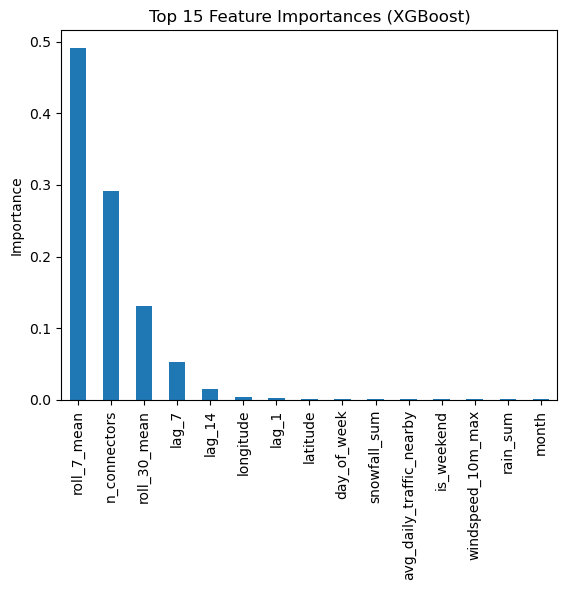

In [22]:
import matplotlib.pyplot as plt

imp = pd.Series(xgb.feature_importances_, index=FEATURES).sort_values(ascending=False).head(15)

plt.figure()
imp.plot(kind="bar")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.ylabel("Importance")
plt.show()


In [24]:
# Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,        # depth of individual trees
    subsample=0.8,    
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# Add to a table
results.append(evaluate(y_test.values, y_pred_gbr, name="Gradient Boosting (GBR)"))

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df


,model,MAE,RMSE,R2
3,Gradient Boosting (GBR),4.040715,5.728778,0.982025
1,Random Forest,4.072276,5.746934,0.981911
2,XGBoost,4.084267,5.831223,0.981376
0,Naive (lag_1),5.757787,8.287136,0.962385


In [26]:
#CSV output
pred_df = df_model.loc[test_mask, ["station_id", "date"]].copy()
pred_df["y_true"] = y_test.values
pred_df["pred_naive"] = y_pred_naive
pred_df["pred_rf"] = y_pred_rf
pred_df["pred_xgb"] = y_pred_xgb
pred_df["pred_gbr"] = y_pred_gbr

pred_df.to_csv(
    r"C:\Users\DuminduS\Desktop\UWE\CSCT Masters Project\datasets\test_predictions.csv",
    index=False
)


In [34]:
#get train and test performance
y_train_pred_gbr = gbr.predict(X_train)

train_mae_gbr = mean_absolute_error(y_train, y_train_pred_gbr)
train_rmse_gbr = np.sqrt(mean_squared_error(y_train, y_train_pred_gbr))
train_r2_gbr = r2_score(y_train, y_train_pred_gbr)



In [36]:
y_train_pred_rf = rf.predict(X_train)

train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)


In [38]:
y_train_pred_xgb = xgb.predict(X_train)

train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)


In [42]:
def get_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


In [44]:
train_metrics_gbr = get_metrics(y_train, gbr.predict(X_train))
test_metrics_gbr  = get_metrics(y_test, gbr.predict(X_test))


In [50]:
gbr_table = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R²"],
    "Training set performance": [
        train_metrics_gbr["MAE"],
        train_metrics_gbr["RMSE"],
        train_metrics_gbr["R2"]
    ],
    "Test set performance": [
        test_metrics_gbr["MAE"],
        test_metrics_gbr["RMSE"],
        test_metrics_gbr["R2"]
    ]
}).round(3)

gbr_table


,Metric,Training set performance,Test set performance
0,MAE,3.873,4.041
1,RMSE,5.226,5.729
2,R²,0.985,0.982


In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


In [56]:
gbr_train = regression_metrics(y_train, gbr.predict(X_train))
gbr_test  = regression_metrics(y_test,  gbr.predict(X_test))


In [58]:
rf_train = regression_metrics(y_train, rf.predict(X_train))
rf_test  = regression_metrics(y_test,  rf.predict(X_test))


In [60]:
naive_pred = y_test.shift(1).dropna()
naive_true = y_test.loc[naive_pred.index]

naive_test = regression_metrics(naive_true, naive_pred)


In [64]:
xgb_train = regression_metrics(y_train, xgb.predict(X_train))
xgb_test  = regression_metrics(y_test,  xgb.predict(X_test))



In [66]:
#final table
results_table = pd.DataFrame([
    ["Naive (lag-1)", "-", "-", "-", 
     naive_test["MAE"], naive_test["RMSE"], naive_test["R2"]],

    ["Random Forest", 
     rf_train["MAE"], rf_train["RMSE"], rf_train["R2"],
     rf_test["MAE"], rf_test["RMSE"], rf_test["R2"]],

    ["XGBoost", 
     xgb_train["MAE"], xgb_train["RMSE"], xgb_train["R2"],
     xgb_test["MAE"], xgb_test["RMSE"], xgb_test["R2"]],

    ["Gradient Boosting (GBR)", 
     gbr_train["MAE"], gbr_train["RMSE"], gbr_train["R2"],
     gbr_test["MAE"], gbr_test["RMSE"], gbr_test["R2"]],
],
columns=[
    "Model",
    "Train MAE", "Train RMSE", "Train R²",
    "Test MAE", "Test RMSE", "Test R²"
])

results_table = results_table.round(3)
results_table


,Model,Train MAE,Train RMSE,Train R²,Test MAE,Test RMSE,Test R²
0,Naive (lag-1),-,-,-,5.917,9.942,0.946
1,Random Forest,1.528616,2.160458,0.99746,4.072,5.747,0.982
2,XGBoost,3.238409,4.157375,0.990593,4.084,5.831,0.981
3,Gradient Boosting (GBR),3.873116,5.225683,0.985138,4.041,5.729,0.982
